In [7]:
# Importing required libraries
import time
import tensorflow as tf
import numpy as np
import os
from pathlib import Path
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Dense, Conv2D, Input, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import keras.backend as K

In [8]:
# Data generator for loading the images from directory
datagen = image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

In [9]:
# Creating the training data generator with batch_size=32 and image size=(256, 256)
train_generator = datagen.flow_from_directory(
        'caltech101_classification',
        # target_size=None,
        batch_size=32,
        shuffle=True,
        seed=np.random.seed(42),
        subset = 'training',
        )

Found 1330 images belonging to 3 classes.


In [10]:
# Creating the validation data generator with batch_size=32 and image size=(256, 256)
val_generator = datagen.flow_from_directory(
        'caltech101_classification',
        # target_size=None,
        batch_size=32,
        shuffle=True,
        seed=np.random.seed(42),
        subset = 'validation',
        )

Found 331 images belonging to 3 classes.


In [11]:
# Utility functions for calculating recall, precision and f1_score respectively
def recall_m(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
# Class object for creating a list of layers given the number of channels and kernel_size
class conv_layer():
  def __init__(self, out_ch=32, kernel_size = 3, activation='relu', downsample=True,):
    self.out_ch = out_ch
    self.kernel_size = kernel_size
    self.downsample = downsample
    self.act_func = activation
    # self.layers = []
    self.conv = Conv2D(self.out_ch, self.kernel_size, padding='same')
    self.batch_norm = BatchNormalization()
    self.activation = Activation(self.act_func)
    self.max_pool = MaxPooling2D(pool_size=(2,2))

  # Method to return the list of layers
  def get_layers(self):
    layers = []
    layers.append(self.conv)
    layers.append(self.activation)
    layers.append(self.batch_norm)
    if self.downsample:
      layers.append(self.max_pool)
    return layers

In [13]:
# Function to create models with different number of layers and neurons
def create_model(n_conv_layers=5, n_dense_layers = 3, input_shape=(256, 256, 3), out_shape=3, show_summary=False):
  layers_list = [Input(input_shape)]   # list of layers
  channel_list = [32, 64, 128, 256, 512, 1024, 2048]
  kernel_list = [3, 3, 3, 3, 3, 3, 3]
  neuron_list = [256, 128, 64, 32, 16, 8, 4]
  for i in range(n_conv_layers):
    cl = conv_layer(out_ch=channel_list[i], kernel_size=kernel_list[i])
    layers_list.extend(cl.get_layers())

  layers_list.append(GlobalAveragePooling2D())
  layers_list.append(Flatten())
  for i in range(n_dense_layers):
    layers_list.append(Dense(neuron_list[i], activation='relu'))
  layers_list.append(Dense(out_shape, activation='softmax'))

  # defining the model
  model = Sequential(layers_list)
  # printing the summary
  if show_summary:
    model.summary()
  return model

###Experimenting with different number of layers and neurons

In [14]:
# Experimenting with different number of neurons in Dense layer and number of layers
model_list1 = []
time_taken1 = []

for i in range(3, 6):
  print("Number of layers: {}".format(i))
  t0 = time.time()
  # Defining the callbacks for saving the model
  cbs = [ModelCheckpoint(filepath='model.neuron{:02d}.h5'.format(i), save_best_only=True),
      TensorBoard(log_dir='./logs_neuron{:02d}'.format(i))]
  # Creating the model
  model = create_model(n_conv_layers=3, n_dense_layers=i, show_summary=False)
  # Compiling the model with optimizers and losses
  model.compile(optimizer=Adam(learning_rate=1e-4), loss=CategoricalCrossentropy(), 
                metrics=['accuracy', f1_score, precision_m, recall_m])
  # fitting the model
  history = model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=cbs)
  model_list1.append({'n_layers':i, 'model':history})
  t1 = time.time()
  delta_t = t1-t0
  print("#"*100)
  time_taken1.append(delta_t)

####################################################################################################
Number of layers: 3
Epoch 1/10
42/42 [==============================] - 35s 634ms/step - loss: 0.5424 - accuracy: 0.8316 - f1_score: 0.3767 - precision_m: 0.9524 - recall_m: 0.2429 - val_loss: 1.0819 - val_accuracy: 0.4834 - val_f1_score: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/10
42/42 [==============================] - 25s 587ms/step - loss: 0.2512 - accuracy: 0.9233 - f1_score: 0.4915 - precision_m: 1.0000 - recall_m: 0.3259 - val_loss: 1.0849 - val_accuracy: 0.4834 - val_f1_score: 0.2118 - val_precision_m: 1.0000 - val_recall_m: 0.1190
Epoch 3/10
42/42 [==============================] - 25s 590ms/step - loss: 0.2037 - accuracy: 0.9323 - f1_score: 0.4941 - precision_m: 1.0000 - recall_m: 0.3281 - val_loss: 1.1521 - val_accuracy: 0.4834 - val_f1_score: 0.5000 - val_precision_m: 1.0000 - val_recall_m: 0.3333
Epoch 4/10
42/42 [========================

In [15]:
# model_list1[0].history.keys()
# dict_keys(['loss', 'accuracy', 'categorical_accuracy', 'f1_score', 'precision_m', 
# 'recall_m', 'val_loss', 'val_accuracy', 'val_categorical_accuracy', 'val_f1_score', 'val_precision_m', 'val_recall_m'])

In [19]:
def plot_fig(model_list, img_path, type='loss', title="Effect of dense layers on training losses",
             ylabel = "loss"):
  plt.figure(figsize=(12, 9))
  for i in range(len(model_list)):
    plt.plot(range(10), model_list[i]['model'].history[type], label='Num layers={}'.format(model_list[i]['n_layers']))

  plt.legend()
  plt.title(title)
  plt.xlabel("Number of epochs")
  plt.ylabel(ylabel)
  plt.savefig(img_path)
  plt.show()

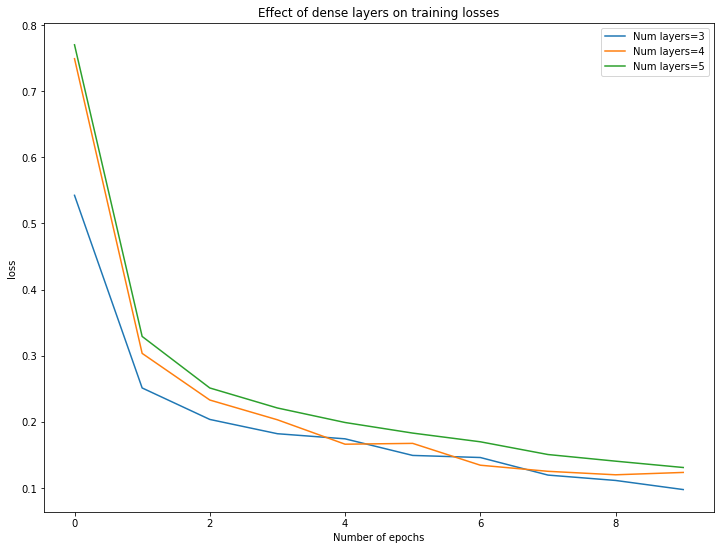

In [20]:
plot_fig(model_list1, "dense_layer_loss.png")

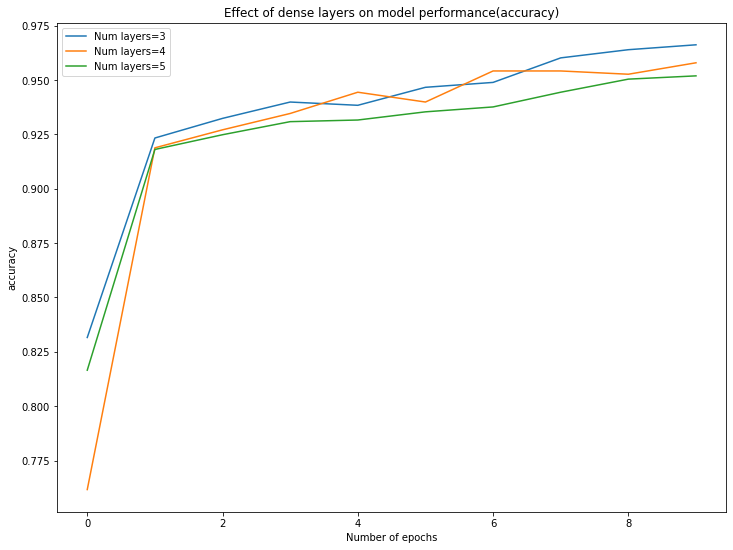

In [21]:
plot_fig(model_list1, "dense_layer_accuracy.png", type='accuracy',  title="Effect of dense layers on model performance(accuracy)",
             ylabel = "accuracy")

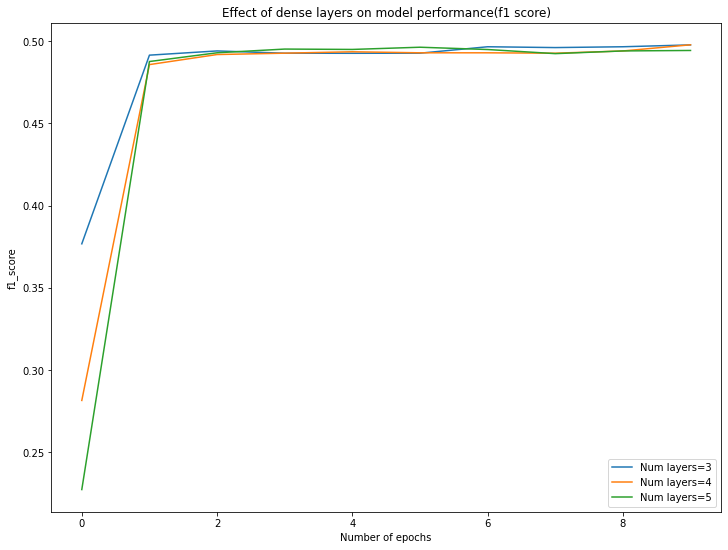

In [22]:
plot_fig(model_list1, "dense_layer_f1_score.png", type='f1_score',  title="Effect of dense layers on model performance(f1 score)",
             ylabel = "f1_score")

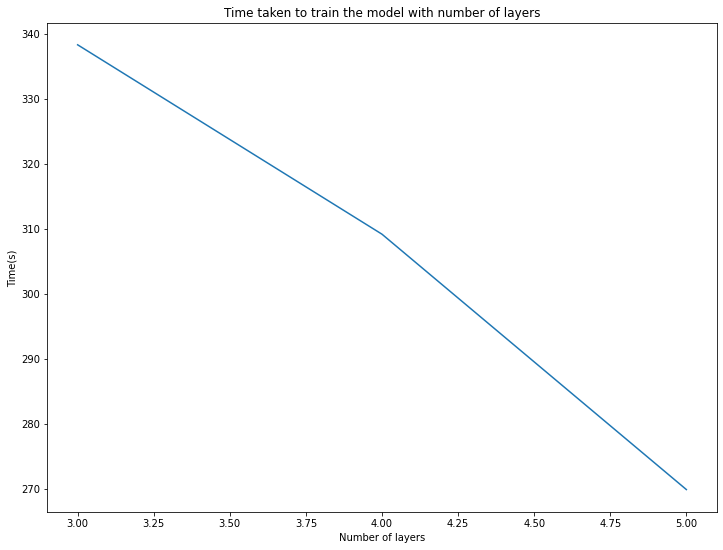

In [24]:
plt.figure(figsize=(12,9))
plt.plot(range(3, 3+len(time_taken1)), time_taken1)
plt.xlabel('Number of layers')
plt.ylabel("Time(s)")
plt.title("Time taken to train the model with number of layers")
plt.savefig("dense_layer_time.png")
plt.show()

In [25]:
# Experimenting with different number of Conv2D layers
model_list2 = []
time_taken2 = []

for i in range(3, 6):
  print("Number of layers: {}".format(i))
  t0 = time.time()
  # Defining the callbacks for saving the model
  cbs = [ModelCheckpoint(filepath='model.conv{:02d}.h5'.format(i), save_best_only=True),
      TensorBoard(log_dir='./logs_conv{:02d}'.format(i))]
  # Creating the model
  model = create_model(n_conv_layers=i, n_dense_layers=3, show_summary=False)
  # Compiling the model with optimizers and losses
  model.compile(optimizer=Adam(learning_rate=1e-4), loss=CategoricalCrossentropy(), 
                metrics=['accuracy', f1_score, precision_m, recall_m])
  # fitting the model
  history = model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=cbs)
  model_list2.append({'n_layers':i, 'model':history})
  t1 = time.time()
  delta_t = t1-t0
  print("#"*100)
  time_taken2.append(delta_t)

Number of layers: 3
Epoch 1/10
42/42 [==============================] - 33s 727ms/step - loss: 0.4646 - accuracy: 0.8872 - f1_score: 0.4336 - precision_m: 1.0000 - recall_m: 0.2832 - val_loss: 1.0673 - val_accuracy: 0.6314 - val_f1_score: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/10
42/42 [==============================] - 30s 722ms/step - loss: 0.2775 - accuracy: 0.9135 - f1_score: 0.4932 - precision_m: 1.0000 - recall_m: 0.3274 - val_loss: 1.0505 - val_accuracy: 0.4834 - val_f1_score: 0.0584 - val_precision_m: 1.0000 - val_recall_m: 0.0302
Epoch 3/10
42/42 [==============================] - 28s 677ms/step - loss: 0.2203 - accuracy: 0.9278 - f1_score: 0.4944 - precision_m: 1.0000 - recall_m: 0.3284 - val_loss: 1.0931 - val_accuracy: 0.4834 - val_f1_score: 0.3996 - val_precision_m: 1.0000 - val_recall_m: 0.2502
Epoch 4/10
42/42 [==============================] - 26s 629ms/step - loss: 0.2027 - accuracy: 0.9301 - f1_score: 0.4918 - precision_m: 1.0000 -

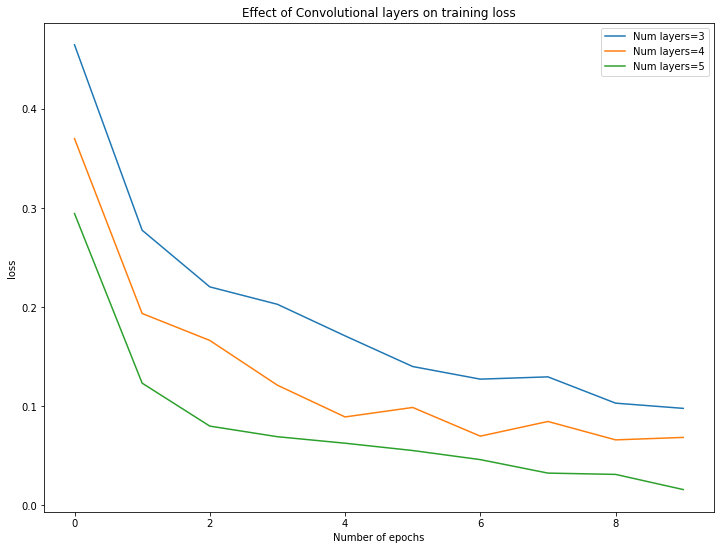

In [26]:
plot_fig(model_list2, "conv_layer_loss.png", type='loss',  title="Effect of Convolutional layers on training loss",
             ylabel = "loss")

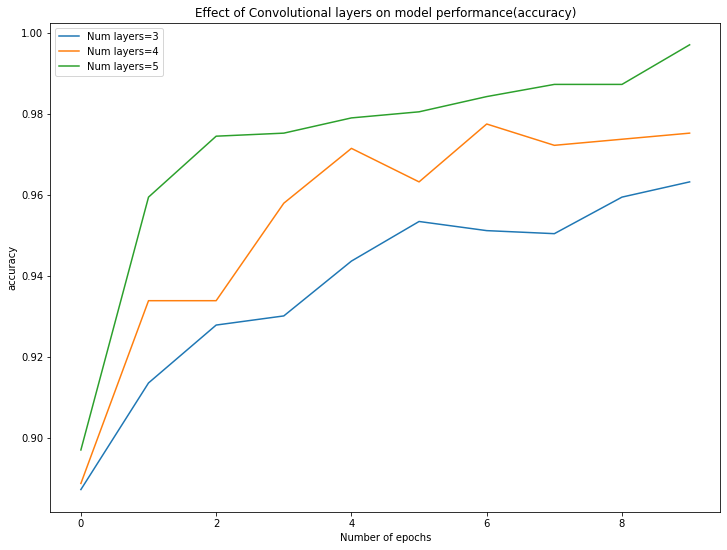

In [27]:
plot_fig(model_list2, "conv_layer_accuracy.png", type='accuracy',  title="Effect of Convolutional layers on model performance(accuracy)",
             ylabel = "accuracy")

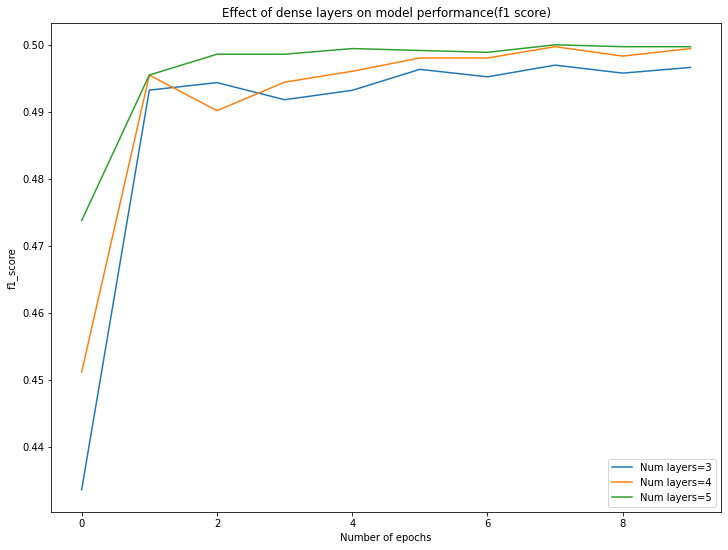

In [28]:
plot_fig(model_list2, "conv_layer_f1_score.png", type='f1_score',  title="Effect of dense layers on model performance(f1 score)",
             ylabel = "f1_score")

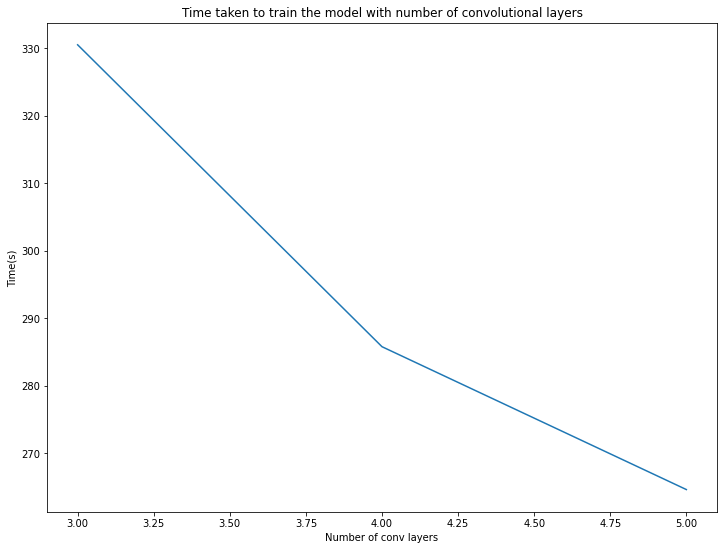

In [29]:
plt.figure(figsize=(12,9))
plt.plot(range(3, 3+len(time_taken2)), time_taken2)
plt.xlabel('Number of conv layers')
plt.ylabel("Time(s)")
plt.title("Time taken to train the model with number of convolutional layers")
plt.savefig("conv_layer_time.png")
plt.show()

In [30]:
!ls

caltech101_classification  dense_layer_time.png  model.conv03.h5
conv_layer_accuracy.png    kaggle.json		 model.conv04.h5
conv_layer_f1_score.png    logs_conv03		 model.conv05.h5
conv_layer_loss.png	   logs_conv04		 model.neuron03.h5
conv_layer_time.png	   logs_conv05		 model.neuron04.h5
dense_layer_accuracy.png   logs_neuron03	 model.neuron05.h5
dense_layer_f1_score.png   logs_neuron04
dense_layer_loss.png	   logs_neuron05


In [32]:
!zip -r submit.zip ./*

  adding: caltech101_classification/ (stored 0%)
  adding: caltech101_classification/Motorbikes/ (stored 0%)
  adding: caltech101_classification/Motorbikes/image_0480.jpg (deflated 7%)
  adding: caltech101_classification/Motorbikes/image_0034.jpg (deflated 4%)
  adding: caltech101_classification/Motorbikes/image_0267.jpg (deflated 1%)
  adding: caltech101_classification/Motorbikes/image_0235.jpg (deflated 1%)
  adding: caltech101_classification/Motorbikes/image_0256.jpg (deflated 2%)
  adding: caltech101_classification/Motorbikes/image_0419.jpg (deflated 6%)
  adding: caltech101_classification/Motorbikes/image_0233.jpg (deflated 2%)
  adding: caltech101_classification/Motorbikes/image_0466.jpg (deflated 6%)
  adding: caltech101_classification/Motorbikes/image_0172.jpg (deflated 2%)
  adding: caltech101_classification/Motorbikes/image_0171.jpg (deflated 1%)
  adding: caltech101_classification/Motorbikes/image_0533.jpg (deflated 9%)
  adding: caltech101_classification/Motorbikes/image_03